In [2]:
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl', context='notebook', ticks=True, grid=False, figsize=(10,6))

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
from collections import OrderedDict, defaultdict

from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary as summary_
import torchvision
import torchvision.transforms as transforms

import data_loader
import utils
import calibration
import train as t

In [4]:
trainloader, validloader = data_loader.get_train_valid_loader(data_dir='./data',
                           batch_size=512,
                           augment=True,
                           random_seed=42,
                           valid_size=0.1,
                           shuffle=False,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
criterion = nn.CrossEntropyLoss()

Using cache found in /home/hyunsikkim/.cache/torch/hub/pytorch_vision_v0.10.0


In [6]:
def load_model(modelname, model_path) : 
    model = torch.hub.load('pytorch/vision:v0.10.0', modelname, pretrained=True)
    hidden_size = model.fc.weight.shape[1]
    model.fc = nn.Linear(hidden_size, len(utils.label_names))

    state_dict = torch.load(model_path)
    adj_state_dict = OrderedDict()
    for k,v in state_dict.items() : 
        adj_state_dict[k.replace("module.",'')] = v

    model.load_state_dict(adj_state_dict)
    model = model.eval().to(device)
    return model

In [7]:
model = load_model('resnet18', 'models/resnet18.20211121.pt')
model = model.eval()

Using cache found in /home/hyunsikkim/.cache/torch/hub/pytorch_vision_v0.10.0


In [8]:
def inference(testloader, device, model, criterion) : 
    prob_container, true_container = list(), list()
    model.eval()
    for inputs, labels in testloader :

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        predictions = outputs.argmax(1)
        acc = (outputs.argmax(1).eq(labels).sum() / outputs.shape[0]).item()

        loss = criterion(outputs, labels)

        prob, true = torch.softmax(outputs, dim=1).cpu().data.numpy(), labels.cpu().data.numpy()

        prob_container.append(prob)
        true_container.append(true)
        
    return np.concatenate(prob_container), np.concatenate(true_container)

In [9]:
prob, true = inference(validloader, device, model, criterion)

/home/hfcp/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
import calibration
uniform_calib_mean = calibration.CalibrationLoss()
uniform_calib_max = calibration.CalibrationLoss(func='max')
quantile_calib_mean = calibration.CalibrationLoss(strategy='quantile')
quantile_calib_max = calibration.CalibrationLoss(strategy='quantile', func='max')

baseline_perf = [uniform_calib_mean.calculate_ce(prob, true), uniform_calib_max.calculate_ce(prob, true),\
quantile_calib_mean.calculate_ce(prob, true), quantile_calib_max.calculate_ce(prob, true)]

In [11]:
recalibration_clf = LogisticRegression().fit(prob, true)
calibrated_prob = recalibration_clf.predict_proba(prob)

In [12]:
import calibration
uniform_calib_mean = calibration.CalibrationLoss()
uniform_calib_max = calibration.CalibrationLoss(func='max')
quantile_calib_mean = calibration.CalibrationLoss(strategy='quantile')
quantile_calib_max = calibration.CalibrationLoss(strategy='quantile', func='max')

calibrated_perf = [uniform_calib_mean.calculate_ce(calibrated_prob, true), uniform_calib_max.calculate_ce(calibrated_prob, true),\
quantile_calib_mean.calculate_ce(calibrated_prob, true), quantile_calib_max.calculate_ce(calibrated_prob, true)]

In [13]:
df = pd.DataFrame([baseline_perf, calibrated_perf], columns=['umean', 'umax', 'qmean', 'qmax'])

<AxesSubplot:>

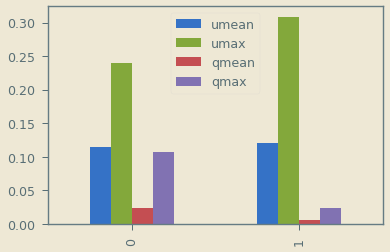

In [14]:
df.plot.bar()

In [ ]:
pd.to_pickle(recalibration_clf, "sigmoid_calibrator.pickle")